# Semantic Movie Recommendation Analysis

This notebook analyzes the semantic embeddings generated from movie descriptions and demonstrates the recommendation system capabilities.

## 1. Setup and Data Loading

In [32]:
# Import libraries
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from src.models.semantic import SemanticRecommender
from sklearn.manifold import TSNE
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully")

Libraries imported successfully


In [33]:
# Import semantic recommendation modules
from src.models.semantic import SemanticEmbedder, SemanticRecommender, TextPreprocessor

print("Semantic modules imported successfully")

Semantic modules imported successfully


In [34]:
# Load the processed data with embeddings
data_path = Path('..') / 'data' / 'processed' / 'semantic_embeddings.parquet'

if not data_path.exists():
    print("ERROR: Embeddings file not found!")
    print("Please run: python src/models/semantic/main.py")
else:
    df = pd.read_parquet(data_path)
    print(f"Data loaded: {len(df):,} movies")
    print(f"Columns: {len(df.columns)}")
    
    # Separate embeddings from metadata
    embed_cols = [col for col in df.columns if col.startswith('embed_')]
    embeddings = df[embed_cols].values
    df_meta = df.drop(columns=embed_cols)
    
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Metadata columns: {list(df_meta.columns)}")

Data loaded: 10,178 movies
Columns: 393
Embeddings shape: (10178, 384)
Metadata columns: ['names', 'overview', 'genre', 'score', 'year', 'revenue', 'overview_processed', 'title_processed', 'genres_text']


In [35]:
# Check what's included in the embeddings
print("Columns in dataset:")
print(df_meta.columns.tolist())
print("\nSample of combined text:")
print(df_meta[['names', 'overview_processed']].head(3))

Columns in dataset:
['names', 'overview', 'genre', 'score', 'year', 'revenue', 'overview_processed', 'title_processed', 'genres_text']

Sample of combined text:
                         names  \
0                    Creed III   
1     Avatar: The Way of Water   
2  The Super Mario Bros. Movie   

                                  overview_processed  
0  creed iii drama action after dominating the bo...  
1  avatar the way of water science_fiction advent...  
2  the super mario bros movie animation adventure...  


In [36]:
# Display sample data
df_meta.head()

names  \
0                    Creed III   
1     Avatar: The Way of Water   
2  The Super Mario Bros. Movie   
3                      Mummies   
4                    Supercell   

                                            overview  \
0  After dominating the boxing world, Adonis Cree...   
1  Set more than a decade after the events of the...   
2  While working underground to fix a water main,...   
3  Through a series of unfortunate events, three ...   
4  Good-hearted teenager William always lived in ...   

                                           genre  score  year       revenue  \
0                                  Drama, Action   73.0  2023  2.716167e+08   
1             Science Fiction, Adventure, Action   78.0  2022  2.316795e+09   
2  Animation, Adventure, Family, Fantasy, Comedy   76.0  2023  7.244590e+08   
3  Animation, Comedy, Family, Adventure, Fantasy   70.0  2023  3.420000e+07   
4                                         Action   61.0  2023  3.409420e+08   

                                  overview_processed  \
0  creed iii drama action after dominating the bo...   
1  avatar the way of water science_fiction advent...   
2  the super mario bros movie animation adventure...   
3  mummies animation comedy family adventure fant...   
4  supercell action good hearted teenager william...   

              title_processed                                genres_text  
0                   creed iii                               drama action  
1     avatar the way of water           science_fiction adventure action  
2  the super mario bros movie  animation adventure family fantasy comedy  
3                     mummies  animation comedy family adventure fantasy  
4                   supercell                                     action

## 2. Text Preprocessing Analysis

In [37]:
# Analyze text lengths 
df_meta['word_count'] = df_meta['overview_processed'].str.split().str.len()
df_meta['char_count'] = df_meta['overview_processed'].str.len()

print("Text Length Statistics (Title + Genres + Overview):")
print("\nWord Count:")
print(df_meta['word_count'].describe())
print("\nCharacter Count:")
print(df_meta['char_count'].describe())

Text Length Statistics (Title + Genres + Overview):

Word Count:
count    10178.00000
mean        54.29328
std         26.76343
min          2.00000
25%         34.00000
50%         49.00000
75%         69.00000
max        196.00000
Name: word_count, dtype: float64

Character Count:
count    10178.000000
mean       313.399391
std        149.594876
min         12.000000
25%        197.000000
50%        282.000000
75%        401.750000
max       1047.000000
Name: char_count, dtype: float64


In [38]:
# Analyze contribution of each component
print("Component Analysis:\n")

# Extract genres if present
if 'genre' in df_meta.columns:
    df_meta['has_genre'] = df_meta['genre'].apply(
        lambda x: x not in ['Unknown', '', None] and not pd.isna(x)
    )
    print(f"Movies with genres: {df_meta['has_genre'].sum()} ({df_meta['has_genre'].sum()/len(df_meta)*100:.1f}%)")
    print(f"Movies without genres: {(~df_meta['has_genre']).sum()} ({(~df_meta['has_genre']).sum()/len(df_meta)*100:.1f}%)")

# Show examples with and without genres
print("\n" + "="*80)
print("Example 1: Movie WITH title and genres")
print("="*80)
with_genre = df_meta[df_meta.get('has_genre', False)].iloc[0]
print(f"Title: {with_genre['names']}")
if 'genre' in df_meta.columns:
    print(f"Genre: {with_genre['genre']}")
print(f"Combined text: {with_genre['overview_processed'][:200]}...")

print("\n" + "="*80)
print("Example 2: Movie WITHOUT genres (if any)")
print("="*80)
if 'has_genre' in df_meta.columns:
    without_genre = df_meta[~df_meta['has_genre']]
    if len(without_genre) > 0:
        example = without_genre.iloc[0]
        print(f"Title: {example['names']}")
        print(f"Genre: {example['genre']}")
        print(f"Combined text: {example['overview_processed'][:200]}...")
    else:
        print("All movies have genres!")
else:
    print("Genre information not available")

Component Analysis:

Movies with genres: 10093 (99.2%)
Movies without genres: 85 (0.8%)

Example 1: Movie WITH title and genres
Title: Creed III
Genre: Drama, Action
Combined text: creed iii drama action after dominating the boxing world adonis creed has been thriving in both his career and family life when a childhood friend and former boxing prodigy damien anderson resurfaces ...

Example 2: Movie WITHOUT genres (if any)
Title: Housewife Sex Slaves: Hatano Yui
Genre: Unknown
Combined text: housewife sex slaves hatano yui we don't have an overview translated in english help us expand our database by adding one...


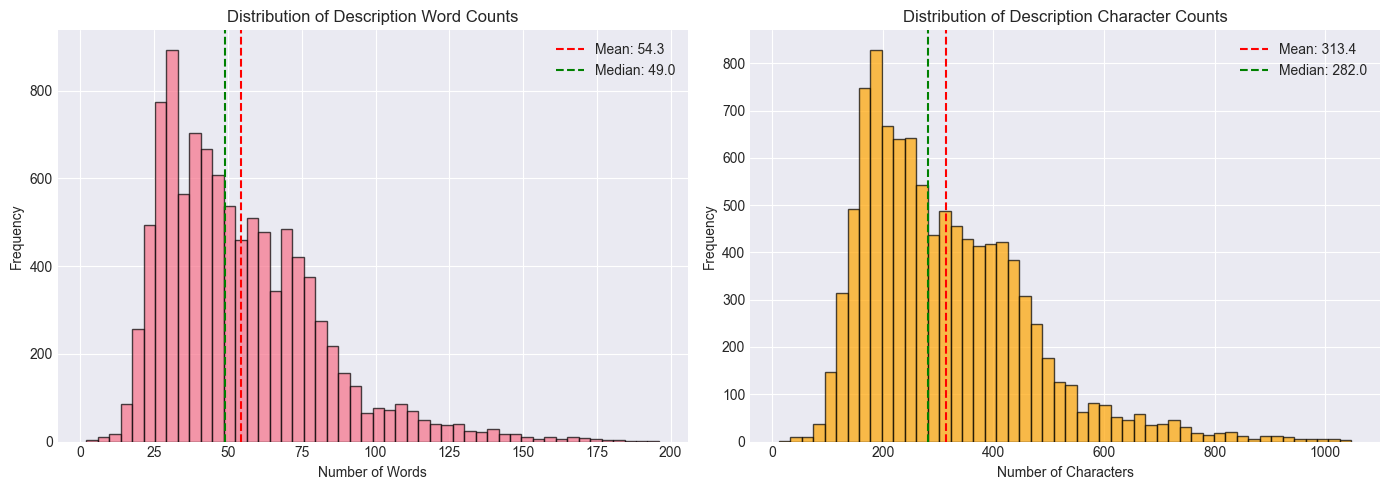

In [39]:
# Visualize text length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Word count distribution
axes[0].hist(df_meta['word_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df_meta['word_count'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_meta["word_count"].mean():.1f}')
axes[0].axvline(df_meta['word_count'].median(), color='green', linestyle='--',
                label=f'Median: {df_meta["word_count"].median():.1f}')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Description Word Counts')
axes[0].legend()

# Character count distribution
axes[1].hist(df_meta['char_count'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(df_meta['char_count'].mean(), color='red', linestyle='--',
                label=f'Mean: {df_meta["char_count"].mean():.1f}')
axes[1].axvline(df_meta['char_count'].median(), color='green', linestyle='--',
                label=f'Median: {df_meta["char_count"].median():.1f}')
axes[1].set_xlabel('Number of Characters')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Description Character Counts')
axes[1].legend()

plt.tight_layout()
plt.show()

In [40]:
# Show examples of preprocessing
print("Examples of Text Preprocessing:\n")

for i in range(3):
    print(f"Movie {i+1}: {df_meta.loc[i, 'names']}")
    print(f"Original ({len(df_meta.loc[i, 'overview'])} chars):")
    print(f"  {df_meta.loc[i, 'overview'][:150]}...")
    print(f"Processed ({len(df_meta.loc[i, 'overview_processed'])} chars):")
    print(f"  {df_meta.loc[i, 'overview_processed'][:150]}...")
    print()

Examples of Text Preprocessing:

Movie 1: Creed III
Original (458 chars):
  After dominating the boxing world, Adonis Creed has been thriving in both his career and family life. When a childhood friend and former boxing prodig...
Processed (470 chars):
  creed iii drama action after dominating the boxing world adonis creed has been thriving in both his career and family life when a childhood friend and...

Movie 2: Avatar: The Way of Water
Original (272 chars):
  Set more than a decade after the events of the first film, learn the story of the Sully family (Jake, Neytiri, and their kids), the trouble that follo...
Processed (319 chars):
  avatar the way of water science_fiction adventure action set more than a decade after the events of the first film learn the story of the sully family...

Movie 3: The Super Mario Bros. Movie
Original (252 chars):
  While working underground to fix a water main, Brooklyn plumbers—and brothers—Mario and Luigi are transported down a mysterious pipe and 

## 3. Embedding Statistics

In [41]:
# Embedding statistics
print("Embedding Statistics:")
print(f"Shape: {embeddings.shape}")
print(f"Total embeddings: {embeddings.shape[0]:,}")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"\nValue statistics:")
print(f"Mean: {embeddings.mean():.6f}")
print(f"Std:  {embeddings.std():.6f}")
print(f"Min:  {embeddings.min():.6f}")
print(f"Max:  {embeddings.max():.6f}")

Embedding Statistics:
Shape: (10178, 384)
Total embeddings: 10,178
Embedding dimension: 384

Value statistics:
Mean: -0.000508
Std:  0.051029
Min:  -0.251619
Max:  0.253264


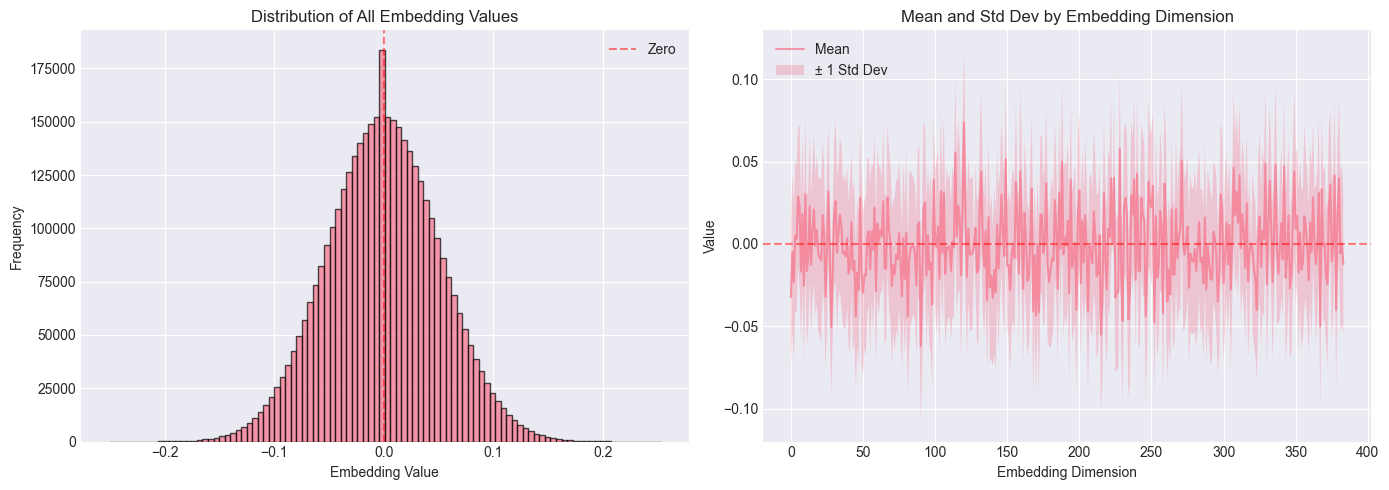

In [42]:
# Visualize embedding value distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
axes[0].hist(embeddings.flatten(), bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Embedding Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of All Embedding Values')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5, label='Zero')
axes[0].legend()

# Per-dimension statistics
dim_means = embeddings.mean(axis=0)
dim_stds = embeddings.std(axis=0)
axes[1].plot(dim_means, alpha=0.7, label='Mean')
axes[1].fill_between(range(len(dim_means)), 
                       dim_means - dim_stds, 
                       dim_means + dim_stds, 
                       alpha=0.3, label='± 1 Std Dev')
axes[1].set_xlabel('Embedding Dimension')
axes[1].set_ylabel('Value')
axes[1].set_title('Mean and Std Dev by Embedding Dimension')
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Dimensionality Reduction and Visualization

In [43]:
# =============================================================================
# t-SNE visualization avec films clés forcés
# =============================================================================


print("🎯 Préparation du sample pour t-SNE...")

# Films clés à inclure obligatoirement
key_movies_to_include = ['Toy Story', 'Avatar', 'Spirited Away']
key_indices = []
recommender = SemanticRecommender(df_meta, embeddings)

for movie in key_movies_to_include:
    idx = recommender.find_movie_index(movie)
    if idx is not None:
        key_indices.append(idx)
        print(f"  ✅ Film clé inclus : {df_meta.loc[idx, 'names']}")

# Taille du sample
n_samples = min(5000, len(embeddings))
remaining_size = n_samples - len(key_indices)

# Indices disponibles (sans les films clés)
all_indices = set(range(len(embeddings)))
available_indices = list(all_indices - set(key_indices))

# Échantillon aléatoire des autres films
random_indices = np.random.choice(available_indices, size=remaining_size, replace=False)

# Combiner : films clés + échantillon aléatoire
sample_indices = np.array(key_indices + list(random_indices))
np.random.shuffle(sample_indices)

print(f"\n📊 Sample créé : {len(sample_indices)} films (dont {len(key_indices)} films clés)")

# Calcul t-SNE
print("\n🔄 Computing t-SNE (this may take a few minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings[sample_indices])

print(f"✅ t-SNE complete. Shape: {embeddings_2d.shape}")

🎯 Préparation du sample pour t-SNE...
  ✅ Film clé inclus : Toy Story
  ✅ Film clé inclus : Avatar
  ✅ Film clé inclus : Spirited Away

📊 Sample créé : 5000 films (dont 3 films clés)

🔄 Computing t-SNE (this may take a few minutes)...
✅ t-SNE complete. Shape: (5000, 2)


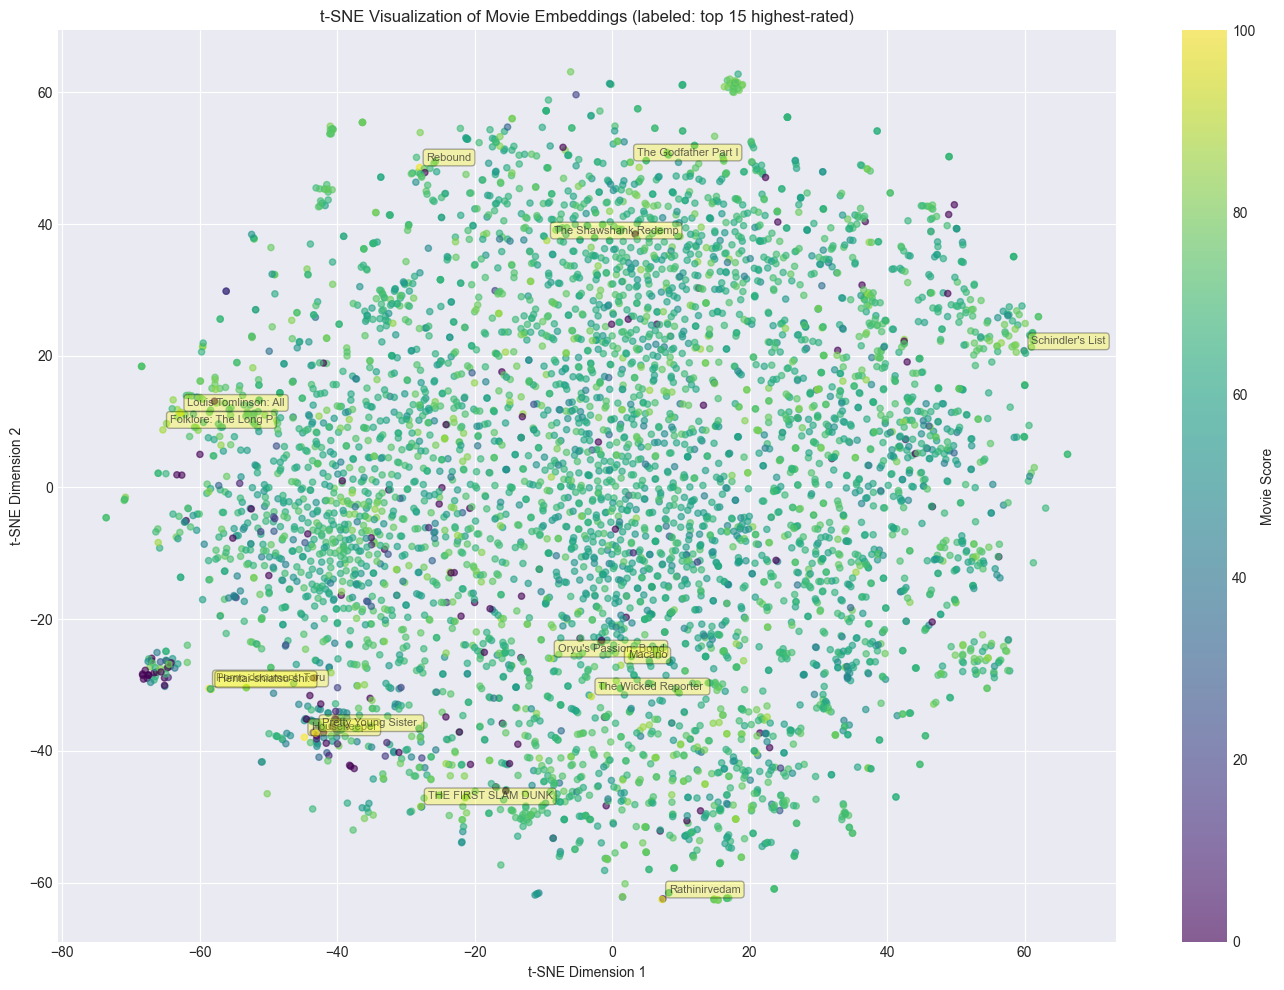

In [44]:
# Visualize t-SNE by movie score
plt.figure(figsize=(14, 10))

scores = df_meta.loc[sample_indices, 'score'].values
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=scores, cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='Movie Score')

# Add labels for some notable movies
movies_to_label = df_meta.loc[sample_indices].nlargest(15, 'score')

for idx, row in movies_to_label.iterrows():
    pos_in_sample = np.where(sample_indices == idx)[0]
    if len(pos_in_sample) > 0:
        pos = pos_in_sample[0]
        plt.annotate(
            row['names'][:20], 
            xy=(embeddings_2d[pos, 0], embeddings_2d[pos, 1]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            alpha=0.7,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3)
        )

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Movie Embeddings (labeled: top 15 highest-rated)')
plt.tight_layout()
plt.show()

In [45]:
# Visualize t-SNE by genre (top genres only)
from collections import Counter

# Extract first genre for each movie
def get_first_genre(genre_str):
    if pd.isna(genre_str) or genre_str == 'Unknown':
        return 'Unknown'
    genres = str(genre_str).split(',')
    return genres[0].strip()

df_meta['first_genre'] = df_meta['genre'].apply(get_first_genre)

# Get top genres
genre_counts = df_meta['first_genre'].value_counts()
top_genres = genre_counts.head(8).index.tolist()

print(f"Top genres: {top_genres}")
print(f"\nGenre distribution:")
for genre in top_genres:
    count = genre_counts[genre]
    pct = count / len(df_meta) * 100
    print(f"  {genre}: {count} ({pct:.1f}%)")

Top genres: ['Drama', 'Action', 'Comedy', 'Horror', 'Animation', 'Thriller', 'Adventure', 'Romance']

Genre distribution:
  Drama: 1868 (18.4%)
  Action: 1565 (15.4%)
  Comedy: 1378 (13.5%)
  Horror: 933 (9.2%)
  Animation: 895 (8.8%)
  Thriller: 577 (5.7%)
  Adventure: 571 (5.6%)
  Romance: 414 (4.1%)



🎯 Ajout des annotations pour films clés...
  ✅ 'Toy Story' - Annotation ajoutée à la position (21.22, 8.68)
  ✅ 'Avatar' - Annotation ajoutée à la position (44.00, 9.50)
  ✅ 'Spirited Away' - Annotation ajoutée à la position (4.50, -36.37)

📊 Total annotations ajoutées : 3/3
✅ t-SNE sauvegardé : figures/semantic_tsne.png et .pdf


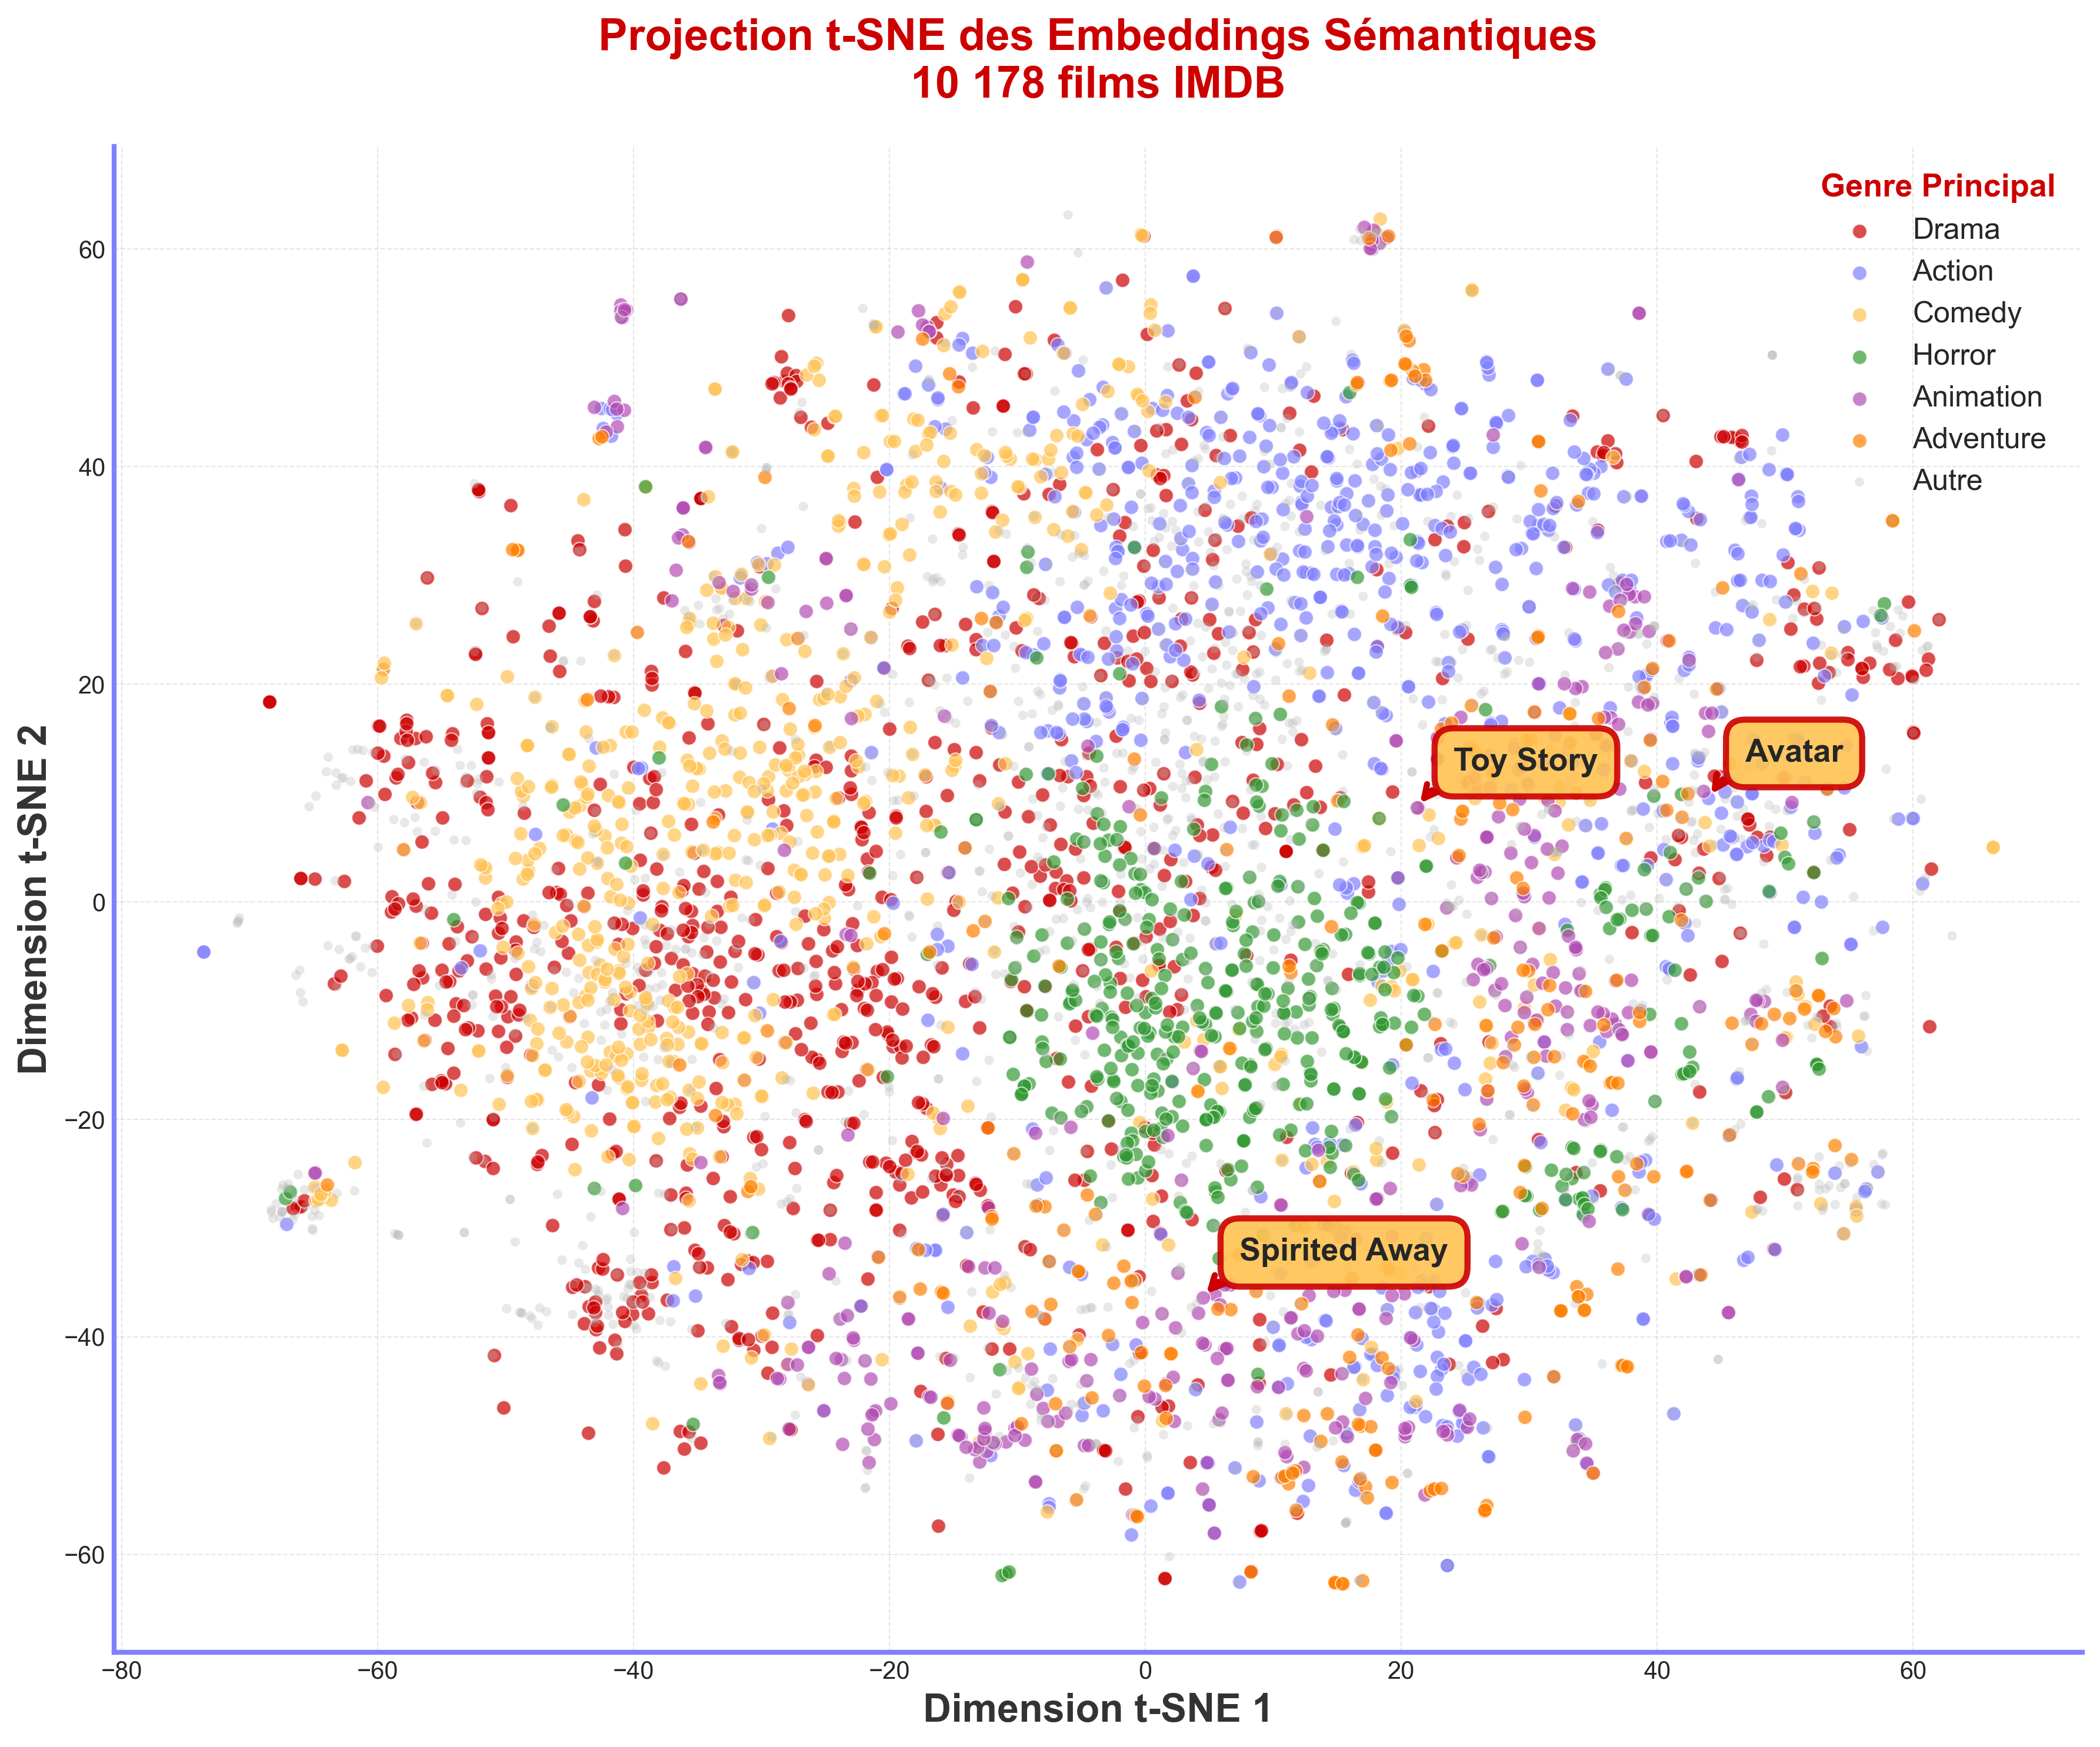

In [46]:
# =============================================================================
# t-SNE avec palette IAA (VERSION POSTER)
# =============================================================================

# Palette IAA
IAA_RED = (0.8, 0, 0)
IAA_BLUE = (0.5, 0.5, 1.0)
IAA_GOLD = (1.0, 0.76, 0.32)
IAA_GRAY = (0.7, 0.7, 0.7)

# Fonction pour extraire le genre principal
def get_main_genre(genre_str):
    if pd.isna(genre_str) or genre_str == '':
        return 'Autre'
    genres = [g.strip() for g in str(genre_str).split(',')]
    return genres[0] if genres else 'Autre'

# Créer la colonne genre principal si elle n'existe pas
if 'main_genre' not in df_meta.columns:
    df_meta['main_genre'] = df_meta['genre'].apply(get_main_genre)

# Extraire les genres du sample
sample_genres = df_meta.loc[sample_indices, 'main_genre'].values

# Top 6 genres
top_genres = pd.Series(sample_genres).value_counts().head(6).index.tolist()

# Palette IAA adaptée aux genres
iaa_palette = [
    IAA_RED,           # Genre 1
    IAA_BLUE,          # Genre 2
    IAA_GOLD,          # Genre 3
    (0.2, 0.6, 0.2),   # Genre 4 - Vert
    (0.7, 0.3, 0.7),   # Genre 5 - Violet
    (1.0, 0.5, 0.0),   # Genre 6 - Orange
]

# Créer figure avec style IAA
fig, ax = plt.subplots(figsize=(12, 10), dpi=300)
ax.set_facecolor('white')

# Plot chaque genre avec palette IAA
for i, genre in enumerate(top_genres):
    mask = sample_genres == genre
    ax.scatter(
        embeddings_2d[mask, 0], 
        embeddings_2d[mask, 1],
        c=[iaa_palette[i]], 
        label=genre,
        alpha=0.7,
        s=35,
        edgecolors='white',
        linewidths=0.5
    )

# Autres genres en gris
other_mask = ~np.isin(sample_genres, top_genres)
ax.scatter(
    embeddings_2d[other_mask, 0], 
    embeddings_2d[other_mask, 1],
    c=[IAA_GRAY], 
    label='Autre',
    alpha=0.3,
    s=15,
    edgecolors='none'
)

# Annotations pour films clés (avec debug)
print("\n🎯 Ajout des annotations pour films clés...")
key_movies = ['Toy Story', 'Avatar', 'Spirited Away']

annotations_added = 0
for movie in key_movies:
    idx = recommender.find_movie_index(movie)
    
    if idx is None:
        print(f"  ❌ '{movie}' - Non trouvé dans le dataset")
        continue
    
    # Vérifier si le film est dans le sample t-SNE
    pos_in_sample = np.where(sample_indices == idx)[0]
    
    if len(pos_in_sample) == 0:
        print(f"  ⚠️  '{movie}' - Trouvé mais pas dans le sample t-SNE")
        continue
    
    # Ajouter l'annotation
    pos = pos_in_sample[0]
    ax.annotate(
        df_meta.loc[idx, 'names'],
        xy=(embeddings_2d[pos, 0], embeddings_2d[pos, 1]),
        xytext=(15, 15),
        textcoords='offset points',
        fontsize=13,
        fontweight='bold',
        bbox=dict(
            boxstyle='round,pad=0.6', 
            fc=IAA_GOLD, 
            alpha=0.9, 
            edgecolor=IAA_RED, 
            linewidth=2.5
        ),
        arrowprops=dict(
            arrowstyle='->', 
            color=IAA_RED, 
            lw=2.5,
            connectionstyle='arc3,rad=0.3'
        ),
        zorder=1000  # Afficher au-dessus de tout
    )
    annotations_added += 1
    print(f"  ✅ '{df_meta.loc[idx, 'names']}' - Annotation ajoutée à la position ({embeddings_2d[pos, 0]:.2f}, {embeddings_2d[pos, 1]:.2f})")

print(f"\n📊 Total annotations ajoutées : {annotations_added}/3")

# Style des axes
ax.set_xlabel('Dimension t-SNE 1', fontsize=16, fontweight='bold', color='#333')
ax.set_ylabel('Dimension t-SNE 2', fontsize=16, fontweight='bold', color='#333')
ax.set_title('Projection t-SNE des Embeddings Sémantiques\n10 178 films IMDB', 
             fontsize=18, fontweight='bold', color=IAA_RED, pad=20)

# Légende stylée
legend = ax.legend(
    title='Genre Principal', 
    loc='upper right', 
    framealpha=0.95, 
    fontsize=12,
    title_fontsize=13,
    edgecolor=IAA_RED,
    fancybox=True,
    shadow=True
)
legend.get_title().set_color(IAA_RED)
legend.get_title().set_weight('bold')

# Grille et bordures
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5, color='gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(IAA_BLUE)
ax.spines['bottom'].set_color(IAA_BLUE)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

plt.tight_layout()

# SAUVEGARDER pour le poster
plt.savefig('../figures/semantic_tsne.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('../figures/semantic_tsne.pdf', bbox_inches='tight', facecolor='white')
print("✅ t-SNE sauvegardé : figures/semantic_tsne.png et .pdf")

plt.show()

## 5. Recommendation System Examples

In [47]:
# Create recommender system
recommender = SemanticRecommender(df_meta, embeddings)
print("Recommender initialized")

Recommender initialized


In [48]:
# Example 1: Test franchise detection (same title)
print("="*80)
print("Example 1: Franchise Detection (Movies with similar titles)")
print("="*80)
print("\nRecommendations for 'Toy Story'\n")

recommendations = recommender.get_similar_movies('Toy Story', top_n=5)

if recommendations is not None:
    for idx, row in recommendations.iterrows():
        # Highlight if title contains "Toy Story"
        is_franchise = "toy story" in row['names'].lower()
        marker = "->" if is_franchise else "  "
        
        print(f"{marker} {row['names']}")
        print(f"   Similarity: {row['similarity_score']:.3f} | Score: {row['score']:.1f} | Year: {int(row['year'])}")
        print(f"   Genre: {row['genre']}")
        print(f"   {row['overview'][:120]}...")
        print()

Example 1: Franchise Detection (Movies with similar titles)

Recommendations for 'Toy Story'


Finding recommendations for: Toy Story
-> Toy Story 3
   Similarity: 0.839 | Score: 78.0 | Year: 2010
   Genre: Animation, Family, Comedy
   Woody, Buzz, and the rest of Andy's toys haven't been played with in years. With Andy about to go to college, the gang f...

-> Toy Story 2
   Similarity: 0.828 | Score: 76.0 | Year: 1999
   Genre: Animation, Comedy, Family
   Andy heads off to Cowboy Camp, leaving his toys to their own devices. Things shift into high gear when an obsessive toy ...

-> Toy Story 4
   Similarity: 0.707 | Score: 75.0 | Year: 2019
   Genre: Family, Adventure, Animation, Comedy, Fantasy
   Woody has always been confident about his place in the world and that his priority is taking care of his kid, whether th...

   Buzz Lightyear of Star Command: The Adventure Begins
   Similarity: 0.556 | Score: 64.0 | Year: 2000
   Genre: Animation, Family, Comedy, Science Fiction, Adventu

In [49]:
# Compare: Impact of including title in embedding
print("="*80)
print("Impact Analysis: Title Inclusion")
print("="*80)

# Find sequels/franchises
franchise_examples = [
    ("Toy Story", ["Toy Story 2", "Toy Story 3", "Toy Story 4"]),
    ("The Dark Knight", ["The Dark Knight Rises", "Batman Begins"]),
    ("Avatar", ["Avatar: The Way of Water"])
]

print("\nExpected improvements for franchises:\n")

for main_movie, sequels in franchise_examples:
    recs = recommender.get_similar_movies(main_movie, top_n=10)
    
    if recs is not None:
        print(f"\n{main_movie}:")
        for sequel in sequels:
            match = recs[recs['names'].str.contains(sequel, case=False, na=False)]
            if len(match) > 0:
                rank = recs.index.get_loc(match.index[0]) + 1
                score = match.iloc[0]['similarity_score']
                print(f"  ✓ {sequel}: Rank #{rank}, Similarity: {score:.3f}")
                if score > 0.80:
                    print(f"    → Excellent! Title boosted the similarity")
                elif score > 0.70:
                    print(f"    → Good similarity")
                else:
                    print(f"    → Moderate similarity")
            else:
                print(f"  ✗ {sequel}: Not in top 10")

Impact Analysis: Title Inclusion

Expected improvements for franchises:


Finding recommendations for: Toy Story

Toy Story:
  ✓ Toy Story 2: Rank #2, Similarity: 0.828
    → Excellent! Title boosted the similarity
  ✓ Toy Story 3: Rank #1, Similarity: 0.839
    → Excellent! Title boosted the similarity
  ✓ Toy Story 4: Rank #3, Similarity: 0.707
    → Good similarity

Finding recommendations for: The Dark Knight

The Dark Knight:
  ✓ The Dark Knight Rises: Rank #1, Similarity: 0.829
    → Excellent! Title boosted the similarity
  ✓ Batman Begins: Rank #5, Similarity: 0.706
    → Good similarity

Finding recommendations for: Avatar

Avatar:
  ✓ Avatar: The Way of Water: Rank #2, Similarity: 0.595
    → Moderate similarity


In [50]:
# Example 2: Animation movie recommendations
print("Example 2: Recommendations for 'Toy Story'\n")

recommendations = recommender.get_similar_movies('Toy Story', top_n=5)

if recommendations is not None:
    for idx, row in recommendations.iterrows():
        print(f"{row['names']}")
        print(f"  Similarity: {row['similarity_score']:.3f} | Score: {row['score']:.1f} | Year: {int(row['year'])}")
        print(f"  Genre: {row['genre']}")
        print(f"  {row['overview'][:150]}...")
        print()

Example 2: Recommendations for 'Toy Story'


Finding recommendations for: Toy Story
Toy Story 3
  Similarity: 0.839 | Score: 78.0 | Year: 2010
  Genre: Animation, Family, Comedy
  Woody, Buzz, and the rest of Andy's toys haven't been played with in years. With Andy about to go to college, the gang find themselves accidentally le...

Toy Story 2
  Similarity: 0.828 | Score: 76.0 | Year: 1999
  Genre: Animation, Comedy, Family
  Andy heads off to Cowboy Camp, leaving his toys to their own devices. Things shift into high gear when an obsessive toy collector named Al McWhiggen, ...

Toy Story 4
  Similarity: 0.707 | Score: 75.0 | Year: 2019
  Genre: Family, Adventure, Animation, Comedy, Fantasy
  Woody has always been confident about his place in the world and that his priority is taking care of his kid, whether that's Andy or Bonnie. But when ...

Buzz Lightyear of Star Command: The Adventure Begins
  Similarity: 0.556 | Score: 64.0 | Year: 2000
  Genre: Animation, Family, Comedy, Science

In [51]:
# Example 3: Drama movie recommendations
print("Example 3: Recommendations for 'The Whale'\n")

recommendations = recommender.get_similar_movies('The Whale', top_n=5)

if recommendations is not None:
    for idx, row in recommendations.iterrows():
        print(f"{row['names']}")
        print(f"  Similarity: {row['similarity_score']:.3f} | Score: {row['score']:.1f} | Year: {int(row['year'])}")
        print(f"  Genre: {row['genre']}")
        print(f"  {row['overview'][:150]}...")
        print()

Example 3: Recommendations for 'The Whale'


Finding recommendations for: The Whale
In the Heart of the Sea
  Similarity: 0.579 | Score: 67.0 | Year: 2015
  Genre: Thriller, Drama, Adventure, Action, History
  In the winter of 1820, the New England whaling ship Essex is assaulted by something no one could believe—a whale of mammoth size and will, and an almo...

The Hunt
  Similarity: 0.543 | Score: 81.0 | Year: 2013
  Genre: Drama
  A teacher lives a lonely life, all the while struggling over his son’s custody. His life slowly gets better as he finds love and receives good news fr...

Detachment
  Similarity: 0.527 | Score: 76.0 | Year: 2011
  Genre: Drama
  A chronicle of three weeks in the lives of several high school teachers, administrators and students through the eyes of substitute teacher, Henry Bar...

Deep Blue Sea 3
  Similarity: 0.525 | Score: 58.0 | Year: 2020
  Genre: Action, Horror, Science Fiction
  Dr. Emma Collins and her team are spending their third summer on the is

## 6. Similarity Analysis

In [52]:
# Compute full similarity matrix for a subset
from sklearn.metrics.pairwise import cosine_similarity

# Select popular movies for heatmap
popular_movies = df_meta.nlargest(20, 'score')
popular_indices = popular_movies.index.tolist()
popular_embeddings = embeddings[popular_indices]

# Compute similarity matrix
similarity_matrix = cosine_similarity(popular_embeddings)

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Movies analyzed: {popular_movies['names'].tolist()}")

Similarity matrix shape: (20, 20)
Movies analyzed: ['Orgasm Lecture 2', 'El asistente', 'Female Boss Hooker', 'Porno document: Toruko tokkyû bin', 'Pretty Young Sister 4', 'The Chosen: Season 3  - Episodes 1 & 2', 'Furin, hentai, monmon chômon', 'Housekeeper', 'Simulant', 'Rebound', 'Rathinirvedam', 'Directing Annabelle: Creation', 'BTS: Permission to Dance on Stage - LA', 'Louis Tomlinson: All of Those Voices', 'La Usurpadora, the Musical', 'Young Mother-in-Law', "Oryu's Passion: Bondage Skin", 'The Wicked Reporter 2: The Rebirth of Horserace Betting', 'Hentai-shiatsu-shi: Shikiyoku no kyôen', 'Charlton Heston: Radical to Right Wing']


Sélection de films pour la heatmap...
  ✓ Toy Story (score: 80.0)
  ✓ Avatar (score: 76.0)
  ✓ Spirited Away (score: 85.0)
  ✓ The Dark Knight (score: 85.0)
  ✓ Inception (score: 84.0)
  ✓ Forrest Gump (score: 85.0)

Calcul de la matrice de similarité complète...
Computing similarity matrix...
Similarity matrix computed: shape (10178, 10178)

✅ Heatmap sauvegardée : figures/semantic_heatmap.png et .pdf


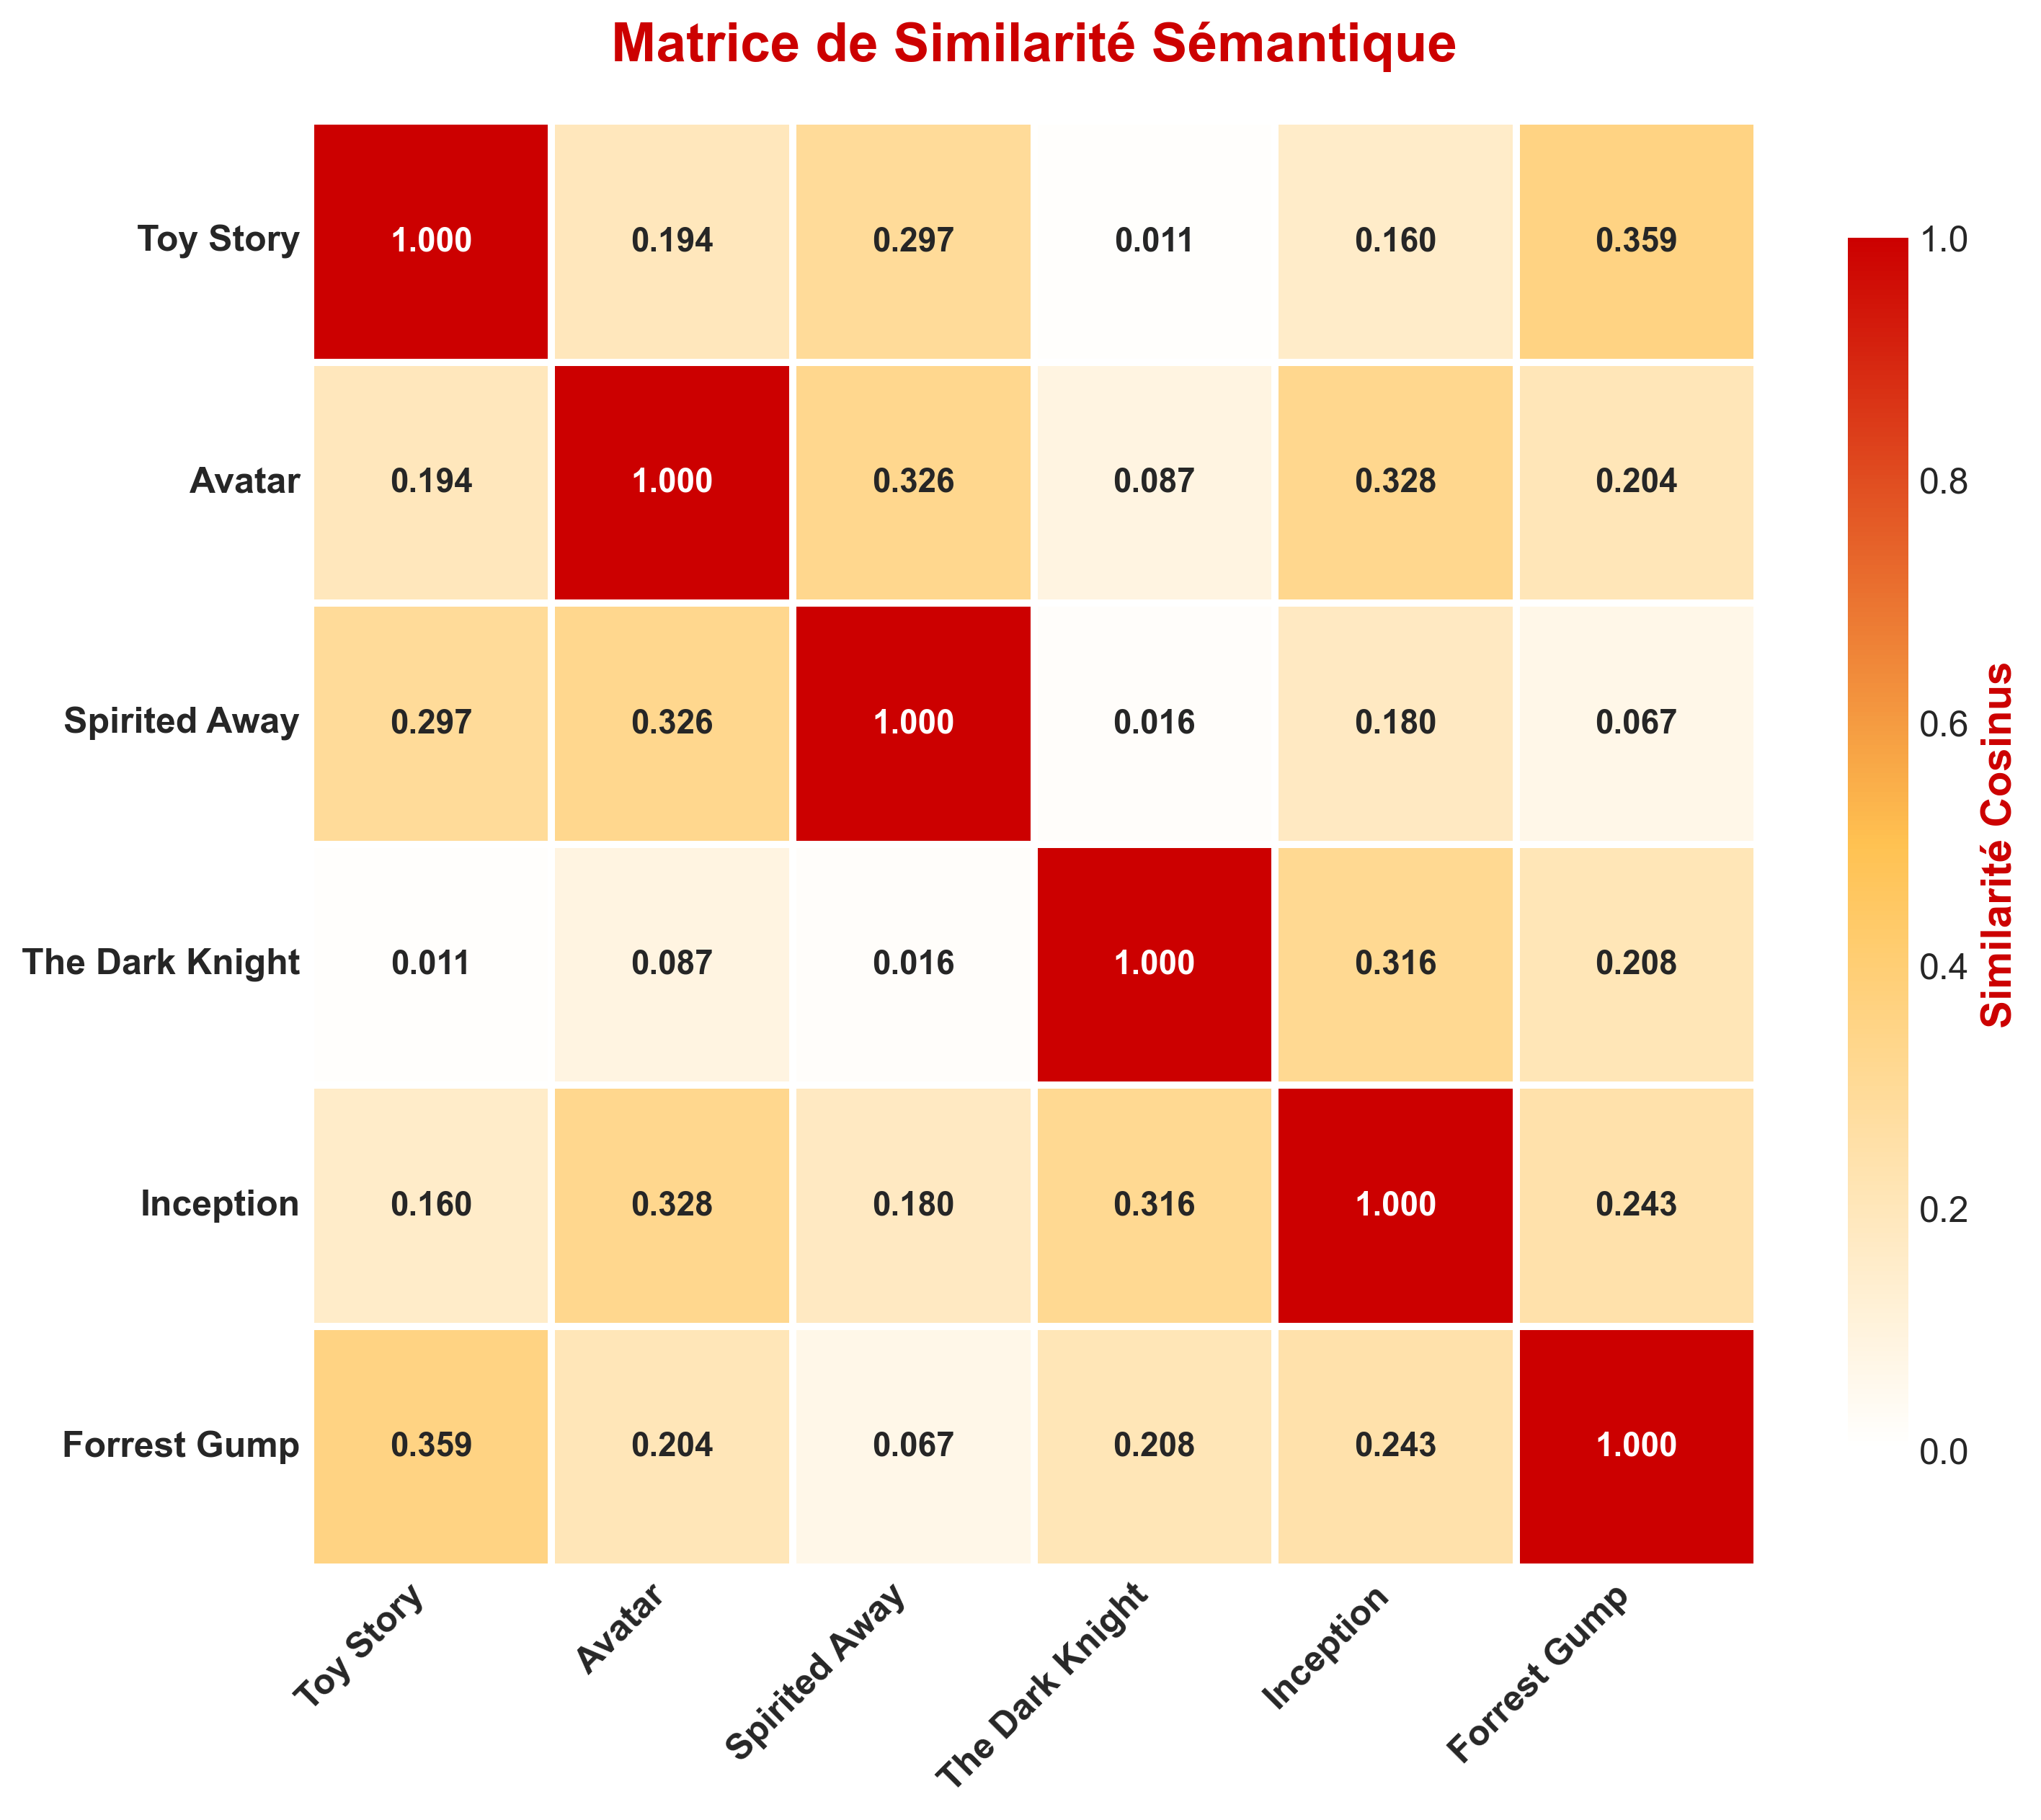

In [53]:
# =============================================================================
# Heatmap compacte avec palette IAA (VERSION POSTER)
# =============================================================================

# Palette IAA
IAA_RED = (0.8, 0, 0)
IAA_GOLD = (1.0, 0.76, 0.32)
IAA_BLUE = (0.5, 0.5, 1.0)

# Sélection de films populaires et bien notés
print("Sélection de films pour la heatmap...")

preferred_movies = [
    'Toy Story', 'Avatar', 'Spirited Away', 
    'The Dark Knight', 'Inception', 'Forrest Gump'
]

selected_indices = []
selected_names = []

for movie in preferred_movies:
    idx = recommender.find_movie_index(movie)
    if idx is not None:
        selected_indices.append(idx)
        selected_names.append(df_meta.loc[idx, 'names'])
        print(f"  ✓ {df_meta.loc[idx, 'names']} (score: {df_meta.loc[idx, 'score']:.1f})")
    else:
        print(f"  ✗ '{movie}' non trouvé dans le dataset")

# Si certains films manquent, compléter avec films bien notés
if len(selected_indices) < 6:
    print("\nComplément avec films top rated...")
    good_movies = df_meta[
        (df_meta['score'] >= 70) & 
        (df_meta['overview_processed'].str.len() > 50)
    ]
    
    top_rated = good_movies.nlargest(20, 'score')
    remaining = 6 - len(selected_indices)
    
    for idx, row in top_rated.iterrows():
        if idx not in selected_indices:
            selected_indices.append(idx)
            selected_names.append(row['names'])
            print(f"  ✓ {row['names']} (score: {row['score']:.1f})")
            remaining -= 1
            if remaining == 0:
                break

# Calculer la sous-matrice de similarité
if recommender.similarity_matrix is None:
    print("\nCalcul de la matrice de similarité complète...")
    recommender.compute_similarity_matrix()

similarity_submatrix = recommender.similarity_matrix[np.ix_(selected_indices, selected_indices)]

# Créer colormap IAA personnalisée
from matplotlib.colors import LinearSegmentedColormap
iaa_cmap = LinearSegmentedColormap.from_list(
    'iaa_heatmap', 
    ['white', IAA_GOLD, IAA_RED],
    N=256
)

# Créer la heatmap
fig, ax = plt.subplots(figsize=(10, 8.5), dpi=300)

sns.heatmap(
    similarity_submatrix, 
    xticklabels=selected_names,
    yticklabels=selected_names,
    cmap=iaa_cmap,
    annot=True,
    fmt='.3f',
    square=True,
    cbar_kws={'label': 'Similarité Cosinus', 'shrink': 0.8},
    linewidths=2,
    linecolor='white',
    vmin=0, 
    vmax=1,
    annot_kws={'fontsize': 11, 'fontweight': 'bold'},
    ax=ax
)

# Style de la colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Similarité Cosinus', fontsize=14, fontweight='bold', color=IAA_RED)

# Titre et axes
ax.set_title(
    'Matrice de Similarité Sémantique', 
    fontsize=18, 
    fontweight='bold', 
    color=IAA_RED,
    pad=20
)

plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')

# Bordures IAA
for spine in ax.spines.values():
    spine.set_edgecolor(IAA_BLUE)
    spine.set_linewidth(3)

plt.tight_layout()

# SAUVEGARDER pour le poster
plt.savefig('../figures/semantic_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('../figures/semantic_heatmap.pdf', bbox_inches='tight', facecolor='white')
print("\n✅ Heatmap sauvegardée : figures/semantic_heatmap.png et .pdf")

plt.show()

In [54]:
# Distribution of similarity scores
# Sample random pairs to avoid computing full matrix
n_pairs = 10000
idx1 = np.random.randint(0, len(embeddings), n_pairs)
idx2 = np.random.randint(0, len(embeddings), n_pairs)

# Compute pairwise similarities
similarities = []
for i in range(n_pairs):
    sim = cosine_similarity(
        embeddings[idx1[i]].reshape(1, -1),
        embeddings[idx2[i]].reshape(1, -1)
    )[0, 0]
    similarities.append(sim)

similarities = np.array(similarities)

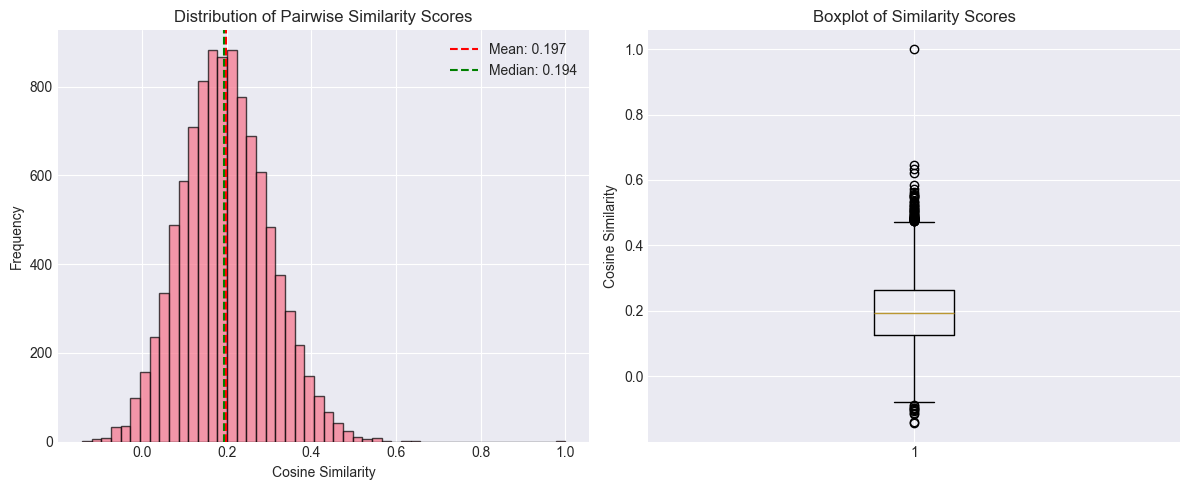

Similarity Statistics:
Mean: 0.1971
Std:  0.1032
Min:  -0.1425
Max:  1.0000


In [55]:
# Plot similarity distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(similarities, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(similarities.mean(), color='red', linestyle='--', 
            label=f'Mean: {similarities.mean():.3f}')
plt.axvline(np.median(similarities), color='green', linestyle='--',
            label=f'Median: {np.median(similarities):.3f}')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Similarity Scores')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(similarities)
plt.ylabel('Cosine Similarity')
plt.title('Boxplot of Similarity Scores')

plt.tight_layout()
plt.show()

print(f"Similarity Statistics:")
print(f"Mean: {similarities.mean():.4f}")
print(f"Std:  {similarities.std():.4f}")
print(f"Min:  {similarities.min():.4f}")
print(f"Max:  {similarities.max():.4f}")

## 7. Genre-Based Analysis

In [56]:
# Analyze similarity within and across genres
def compute_genre_similarities(df, embeddings, genre, n_samples=100):
    """
    Compute average similarity within a genre and with other genres.
    """
    genre_mask = df['first_genre'] == genre
    genre_indices = df[genre_mask].index.tolist()
    
    if len(genre_indices) < 2:
        return None, None
    
    # Sample if too many
    if len(genre_indices) > n_samples:
        genre_indices = np.random.choice(genre_indices, n_samples, replace=False)
    
    genre_embeddings = embeddings[genre_indices]
    
    # Within-genre similarity
    within_sim = cosine_similarity(genre_embeddings)
    # Remove diagonal (self-similarity)
    within_sim = within_sim[np.triu_indices_from(within_sim, k=1)]
    
    # Across-genre similarity
    other_indices = df[~genre_mask].index.tolist()
    if len(other_indices) > n_samples:
        other_indices = np.random.choice(other_indices, n_samples, replace=False)
    
    other_embeddings = embeddings[other_indices]
    across_sim = cosine_similarity(genre_embeddings, other_embeddings).flatten()
    
    return within_sim, across_sim

In [57]:
# Analyze top genres
genre_analysis = {}

for genre in top_genres:
    within, across = compute_genre_similarities(df_meta, embeddings, genre)
    if within is not None:
        genre_analysis[genre] = {
            'within_mean': within.mean(),
            'within_std': within.std(),
            'across_mean': across.mean(),
            'across_std': across.std(),
        }

# Display results
genre_df = pd.DataFrame(genre_analysis).T
genre_df['difference'] = genre_df['within_mean'] - genre_df['across_mean']
genre_df = genre_df.sort_values('difference', ascending=False)

print("Genre Similarity Analysis:")
print("\nGenres with highest within-genre similarity:")
print(genre_df[['within_mean', 'across_mean', 'difference']])

Genre Similarity Analysis:

Genres with highest within-genre similarity:
           within_mean  across_mean  difference
Horror        0.315607     0.187944    0.127662
Animation     0.260720     0.172548    0.088172
Comedy        0.247511     0.182531    0.064980
Action        0.236309     0.186985    0.049325
Adventure     0.236650     0.192213    0.044437
Drama         0.224846     0.195229    0.029617


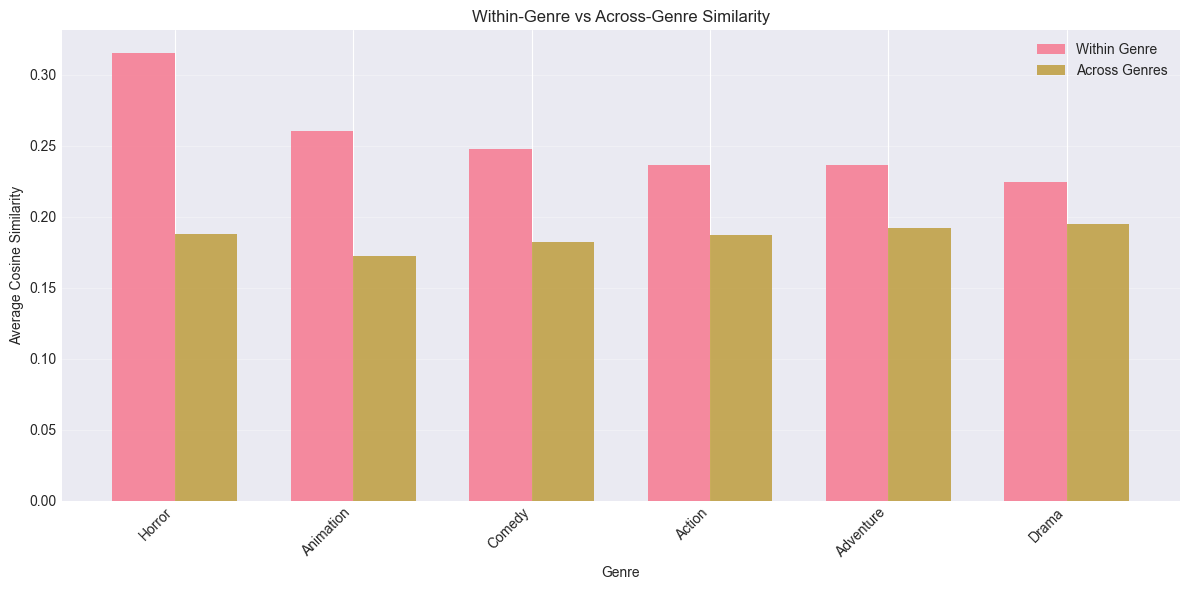

In [58]:
# Visualize genre similarity analysis
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(genre_df))
width = 0.35

ax.bar(x - width/2, genre_df['within_mean'], width, label='Within Genre', alpha=0.8)
ax.bar(x + width/2, genre_df['across_mean'], width, label='Across Genres', alpha=0.8)

ax.set_xlabel('Genre')
ax.set_ylabel('Average Cosine Similarity')
ax.set_title('Within-Genre vs Across-Genre Similarity')
ax.set_xticks(x)
ax.set_xticklabels(genre_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Genre Impact on Recommendations

In [59]:
print("="*80)
print("Genre Impact Analysis")
print("="*80)

# Select a few movies and analyze if recommendations share genres
test_movies = ["Avatar", "Toy Story", "The Dark Knight"]

for movie_title in test_movies:
    idx = recommender.find_movie_index(movie_title)
    if idx is None:
        continue
    
    original_genre = df_meta.loc[idx, 'genre']
    original_genres_set = set(get_first_genre(original_genre).split(','))
    
    print(f"\n{'='*60}")
    print(f"Movie: {movie_title}")
    print(f"Genres: {original_genre}")
    print(f"{'='*60}")
    
    recs = recommender.get_similar_movies(movie_title, top_n=10)
    
    if recs is not None:
        genre_matches = 0
        for idx, row in recs.iterrows():
            rec_genres = set(get_first_genre(row['genre']).split(','))
            has_common = bool(original_genres_set & rec_genres)
            
            if has_common:
                genre_matches += 1
            
            marker = "✓" if has_common else " "
            print(f"  {marker} {row['names']} ({row['similarity_score']:.3f})")
            print(f"     Genres: {row['genre']}")
        
        print(f"\nGenre overlap: {genre_matches}/10 recommendations ({genre_matches*10}%)")
        if genre_matches >= 7:
            print("→ Strong genre coherence! Genres are helping recommendations.")
        elif genre_matches >= 4:
            print("→ Moderate genre coherence.")
        else:
            print("→ Low genre coherence - recommendations based more on content.")

Genre Impact Analysis

Movie: Avatar
Genres: Action, Adventure, Fantasy, Science Fiction

Finding recommendations for: Avatar
    Strange World (0.616)
     Genres: Animation, Family, Adventure, Science Fiction
    Avatar: The Way of Water (0.595)
     Genres: Science Fiction, Adventure, Action
    Jurassic World Dominion (0.579)
     Genres: Adventure, Action, Science Fiction
  ✓ Pacific Rim (0.578)
     Genres: Action, Science Fiction, Adventure
    Age of Tomorrow (0.562)
     Genres: Thriller, Science Fiction, Action
    Eternals (0.561)
     Genres: Science Fiction, Action, Adventure
    Fantastic Planet (0.560)
     Genres: Animation, Science Fiction
    Titan A.E. (0.557)
     Genres: Animation, Action, Science Fiction, Family, Adventure
    Star Wars: The Force Awakens (0.556)
     Genres: Adventure, Action, Science Fiction, Fantasy
    Serenity (0.555)
     Genres: Science Fiction, Action, Adventure, Thriller

Genre overlap: 1/10 recommendations (10%)
→ Low genre coherence - r

## 9. Interactive Recommendation Testing

In [60]:
# Function to test recommendations interactively
def test_recommendation(movie_title, top_n=5):
    """
    Test recommendation system for a given movie.
    """
    print(f"\nRecommendations for: {movie_title}")
    print("="*80)
    
    recommendations = recommender.get_similar_movies(movie_title, top_n=top_n)
    
    if recommendations is not None:
        for i, (idx, row) in enumerate(recommendations.iterrows(), 1):
            print(f"\n{i}. {row['names']}")
            print(f"   Similarity: {row['similarity_score']:.3f}")
            print(f"   Score: {row['score']:.1f} | Year: {int(row['year'])} | Genre: {row['genre']}")
            print(f"   {row['overview'][:200]}...")
    
    return recommendations

In [61]:
# Test with different movies
# Change the movie title to test different recommendations
test_recommendation('Spirited Away', top_n=5)


Recommendations for: Spirited Away

Finding recommendations for: Spirited Away

1. Child of Kamiari Month
   Similarity: 0.625
   Score: 66.0 | Year: 2021 | Genre: Animation, Drama, Fantasy, Family
   A year after losing her mother, a young girl learns that she must journey across Japan to the annual gathering of gods in the sacred land of Izumo....

2. Ponyo
   Similarity: 0.609
   Score: 77.0 | Year: 2009 | Genre: Animation, Fantasy, Family
   From the legendary Studio Ghibli, creators of Spirited Away and My Neighbor Totoro, and Academy Award®-winning director Hayao Miyazaki, comes a heartwarming adventure. When Sosuke, a young boy who liv...

3. Wolfwalkers
   Similarity: 0.601
   Score: 83.0 | Year: 2020 | Genre: Animation, Family, Adventure, Fantasy
   In a time of superstition and magic, when wolves are seen as demonic and nature an evil to be tamed, a young apprentice hunter comes to Ireland with her father to wipe out the last pack. But when she ...

4. Belle
   Similarity: 0

names  similarity_score  score  year  \
1103  Child of Kamiari Month          0.624596   66.0  2021   
841                    Ponyo          0.608633   77.0  2009   
6164             Wolfwalkers          0.601067   83.0  2020   
939                    Belle          0.596984   79.0  2022   
1366      My Neighbor Totoro          0.593046   81.0  1991   

                                      genre  \
1103      Animation, Drama, Fantasy, Family   
841              Animation, Fantasy, Family   
6164  Animation, Family, Adventure, Fantasy   
939      Animation, Science Fiction, Family   
1366             Fantasy, Animation, Family   

                                               overview  
1103  A year after losing her mother, a young girl l...  
841   From the legendary Studio Ghibli, creators of ...  
6164  In a time of superstition and magic, when wolv...  
939   Suzu is a 17-year-old high-school student livi...  
1366  Two sisters move to the country with their fat...

In [62]:
# Test with custom description
custom_description = "The animals from the African jungle fall through a time portal that the aliens forgot to close behind them. To return to the future, friends will need the help of dinosaurs. But the ancient lizards have their own problems. After all, their world is about to be invaded by cave aliens armed with clubs."

print(f"Finding movies similar to: '{custom_description}'")
print("="*80)

# Load embedder
embedder = SemanticEmbedder(model_name='all-MiniLM-L6-v2')
embedder.load_model()

recommendations = recommender.get_recommendations_by_description(
    custom_description,
    embedder,
    top_n=5
)

for i, (idx, row) in enumerate(recommendations.iterrows(), 1):
    print(f"\n{i}. {row['names']}")
    print(f"   Similarity: {row['similarity_score']:.3f}")
    print(f"   Score: {row['score']:.1f} | Year: {int(row['year'])} | Genre: {row['genre']}")
    print(f"   {row['overview'][:200]}...")

Finding movies similar to: 'The animals from the African jungle fall through a time portal that the aliens forgot to close behind them. To return to the future, friends will need the help of dinosaurs. But the ancient lizards have their own problems. After all, their world is about to be invaded by cave aliens armed with clubs.'
Loading SentenceTransformer model: all-MiniLM-L6-v2
Model loaded successfully. Embedding dimension: 384

1. The Land Before Time: The Great Valley Adventure
   Similarity: 0.537
   Score: 63.0 | Year: 1994 | Genre: Animation, Adventure, Family
   After his tribe of herbivorous dinosaurs moves to the carnivore-free Peaceful Valley, young Littlefoot and his friends chase after a pair of dangerous dinosaurs stealing an egg from the village. While...

2. The Dinosaur Project
   Similarity: 0.525
   Score: 56.0 | Year: 2013 | Genre: Adventure, Action, Horror
   Found footage of an expedition into the Congo jungle where a team of explorers stumbles upon a colony of D